In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('Laptop Preference Survey.csv')

# Clean up column names to remove spaces and special characters
df.columns = df.columns.str.replace(' ', '_').str.replace(':', '').str.replace('[', '').str.replace(']', '').str.replace('?', '')

In [3]:
# Create a preference score by summing the importance ratings
df['Preference_Score'] = df[
    ['Which_feature_is_most_important_to_you_when_choosing_a_laptop_Processor',
     'Which_feature_is_most_important_to_you_when_choosing_a_laptop_RAM',
     'Which_feature_is_most_important_to_you_when_choosing_a_laptop_Storage',
     'Which_feature_is_most_important_to_you_when_choosing_a_laptop_Battery_Life',
     'Which_feature_is_most_important_to_you_when_choosing_a_laptop_Screen_Size']
].sum(axis=1)

In [4]:
# Filter relevant columns for analysis
relevant_columns = [
    'Preference_Score', 'Processor_Type', 'Screen_Size', 'RAM', 'Storage_Capacity', 'Battery_Life', 'Price_Range'
]
data_filtered = df[relevant_columns]

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_encoded = encoder.fit_transform(data_filtered.drop(columns=['Preference_Score']))

In [5]:
# Fit a linear regression model
y = data_filtered['Preference_Score']
model = LinearRegression()
model.fit(X_encoded, y)

LinearRegression()

In [6]:
# Extract part-worth utilities
part_worths = model.coef_

# Calculate attribute importance
attribute_importance = {}
for i, feature in enumerate(encoder.get_feature_names_out()):
    attribute = feature.split('_')[0]
    if attribute not in attribute_importance:
        attribute_importance[attribute] = []
    attribute_importance[attribute].append(part_worths[i])

In [7]:
# Calculate the range of part-worth utilities for each attribute
for attribute in attribute_importance:
    attribute_importance[attribute] = max(attribute_importance[attribute]) - min(attribute_importance[attribute])

# Normalize the importance scores
total_importance = sum(attribute_importance.values())
for attribute in attribute_importance:
    attribute_importance[attribute] /= total_importance

print("Attribute Importance:")
print(attribute_importance)

Attribute Importance:
{'Processor': 0.12014113362620453, 'Screen': 0.09722428514045905, 'RAM': 0.20381166934839248, 'Storage': 0.1757875941216444, 'Battery': 0.0770413056985501, 'Price': 0.3259940120647494}


In [8]:
# Simulate market scenarios
new_profiles = pd.DataFrame({
    'Processor_Type': ['i5', 'i7'],
    'Screen_Size': ['13_inches', '15_inches'],
    'RAM': ['8_gb', '16_gb'],
    'Storage_Capacity': ['256_gb', '512_gb'],
    'Battery_Life': ['Upto_5_hours', '5-10_hours'],
    'Price_Range': ['Upto_50k', '50_to_75k']
})

In [9]:
# One-hot encode new profiles
X_new_encoded = encoder.transform(new_profiles)

# Predict preferences for new profiles
predicted_preferences = model.predict(X_new_encoded)
print("Predicted Preferences for New Profiles:")
print(predicted_preferences)

Predicted Preferences for New Profiles:
[18.96001526 17.14999966]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
# Additional analysis and model fitting
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the features with `with_mean=False` to handle sparse matrices
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Feature selection using RFE (Recursive Feature Elimination)
selector = RFE(model, n_features_to_select=10, step=1)
selector = selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

In [12]:
# Fit a Random Forest model with hyperparameter tuning using RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None]
}
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_iter=10, random_state=42)
random_search_rf.fit(X_train_selected, y_train)
best_rf = random_search_rf.best_estimator_

In [13]:
# Predict and calculate the mean squared error for Random Forest model
y_pred_rf = best_rf.predict(X_test_selected)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')
print(f'Mean Absolute Error (Random Forest): {mae_rf}')

Mean Squared Error (Random Forest): 54.4118897620319
R-squared (Random Forest): -0.043595115308017185
Mean Absolute Error (Random Forest): 5.588582451499118


In [14]:
# Cross-validation scores for Random Forest model
rf_cv_scores = cross_val_score(best_rf, X_encoded, y, cv=5, scoring='neg_mean_squared_error')
print(f'Random Forest CV Mean Squared Error: {-rf_cv_scores.mean()}')

Random Forest CV Mean Squared Error: 35.709151775640386


In [15]:
# Add polynomial features for Ridge and Lasso regression models
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

In [16]:
# Fit a Ridge regression model with hyperparameter tuning using GridSearchCV
ridge = Ridge()
param_grid_ridge = {'alpha': [0.1, 0.5, 1.0, 10.0]}
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_poly, y_train)
best_ridge = grid_search_ridge.best_estimator_

In [17]:
# Predict and calculate the mean squared error for Ridge regression model
y_pred_ridge = best_ridge.predict(X_test_poly)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f'Mean Squared Error (Ridge): {mse_ridge}')
print(f'R-squared (Ridge): {r2_ridge}')
print(f'Mean Absolute Error (Ridge): {mae_ridge}')

Mean Squared Error (Ridge): 65.4795519395657
R-squared (Ridge): -0.2558678049144194
Mean Absolute Error (Ridge): 6.177460363495585


In [18]:
# Fit a Lasso regression model with hyperparameter tuning using GridSearchCV
lasso = Lasso()
param_grid_lasso = {'alpha': [0.1, 0.5, 1.0, 10.0]}
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_poly, y_train)
best_lasso = grid_search_lasso.best_estimator_

# Predict and calculate the mean squared error for Lasso regression model
y_pred_lasso = best_lasso.predict(X_test_poly)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f'Mean Squared Error (Lasso): {mse_lasso}')
print(f'R-squared (Lasso): {r2_lasso}')
print(f'Mean Absolute Error (Lasso): {mae_lasso}')

Mean Squared Error (Lasso): 52.154513888888886
R-squared (Lasso): -0.00029968034096961027
Mean Absolute Error (Lasso): 5.819444444444444


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055885942594436244, tolerance: 0.046294736842105264
  model = cd_fast.sparse_enet_coordinate_descent(


In [19]:
# Print the coefficients of Ridge regression model
print(f'Coefficients (Ridge): {best_ridge.coef_}')

Coefficients (Ridge): [-3.30510192e-02 -5.41587735e-04 -5.74413426e-02 -2.73082269e-02
 -6.04601999e-02 -5.47554616e-02  1.14624270e-02 -3.81154378e-02
  1.06993357e-01  7.66080715e-02 -1.19583087e-01  0.00000000e+00
  5.21477747e-02 -2.08526630e-01  0.00000000e+00  0.00000000e+00
  5.07778001e-02  6.59622972e-02  0.00000000e+00  0.00000000e+00
 -1.14888108e-03 -5.56825286e-01  0.00000000e+00  4.03010480e-01
  3.66456013e-01 -6.61592106e-01  0.00000000e+00  3.96898541e-01
  0.00000000e+00 -1.21851489e-01  0.00000000e+00  2.67446076e-01
  1.27040557e-01 -2.58566922e-01  3.83701837e-01  1.24172410e-01
  0.00000000e+00 -9.88048827e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.09721748e-01
 -1.33017059e-01 -5.00527241e-01  2.16735497e-01  0.00000000e+00
 -4.27210143e-01  0.00000000e+00 -1.46924321e-01  0.00000000e+00
  0.00000000e+00 -2.52223257e-01  0.00000000e+00  2.36766874e-02
 -7.87309097e-02  4.15166081e-01  0.00000000e+00 -1.02274452e-01
  0

In [20]:
# Cross-validation scores for Ridge and Lasso regression models
ridge_cv_scores = cross_val_score(best_ridge, X_encoded, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_scores = cross_val_score(best_lasso, X_encoded, y, cv=5, scoring='neg_mean_squared_error')
print(f'Ridge CV Mean Squared Error: {-ridge_cv_scores.mean()}')
print(f'Lasso CV Mean Squared Error: {-lasso_cv_scores.mean()}')

Ridge CV Mean Squared Error: 29.52708009768626
Lasso CV Mean Squared Error: 28.765972222222217


In [21]:
# Create a pipeline with polynomial features and LassoCV
lasso_cv_pipeline = make_pipeline(poly, LassoCV(cv=5))

# Fit the LassoCV pipeline model
lasso_cv_pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('lassocv', LassoCV(cv=5))])

In [44]:
# Predict and calculate the mean squared error for LassoCV pipeline model
y_pred_lasso_cv_pipeline = lasso_cv_pipeline.predict(X_test_scaled)
mse_lasso_cv_pipeline = mean_squared_error(y_test, y_pred_lasso_cv_pipeline)
r2_lasso_cv_pipeline = r2_score(y_test, y_pred_lasso_cv_pipeline)
mae_lasso_cv_pipeline = mean_absolute_error(y_test, y_pred_lasso_cv_pipeline)
print(f'Mean Squared Error (LassoCV Pipeline): {mse_lasso_cv_pipeline}')
print(f'R-squared (LassoCV Pipeline): {r2_lasso_cv_pipeline}')
print(f'Mean Absolute Error (LassoCV Pipeline): {mae_lasso_cv_pipeline}')

Mean Squared Error (LassoCV Pipeline): 52.154513888888886
R-squared (LassoCV Pipeline): -0.00029968034096961027
Mean Absolute Error (LassoCV Pipeline): 5.819444444444444


In [46]:
# Cross-validation scores for LassoCV pipeline model
lasso_cv_pipeline_scores = cross_val_score(lasso_cv_pipeline, X_encoded, y, cv=5, scoring='neg_mean_squared_error')
print(f'LassoCV Pipeline Mean Squared Error: {-lasso_cv_pipeline_scores.mean()}')

LassoCV Pipeline Mean Squared Error: 28.765972222222224


In [48]:
# Detect outliers in the training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
yhat_iso_forest = iso_forest.fit_predict(X_train_scaled)

# Select all rows that are not outliers
mask_iso_forest = yhat_iso_forest != -1
X_train_scaled_cleaned, y_train_cleaned = X_train_scaled[mask_iso_forest], y_train[mask_iso_forest]

In [50]:
# Fit the LassoCV pipeline model again with the cleaned data
lasso_cv_pipeline.fit(X_train_scaled_cleaned, y_train_cleaned)

# Predict and calculate the mean squared error for LassoCV pipeline model after outlier removal
y_pred_lasso_cv_cleaned = lasso_cv_pipeline.predict(X_test_scaled)
mse_lasso_cv_cleaned = mean_squared_error(y_test, y_pred_lasso_cv_cleaned)
r2_lasso_cv_cleaned = r2_score(y_test, y_pred_lasso_cv_cleaned)
mae_lasso_cv_cleaned = mean_absolute_error(y_test, y_pred_lasso_cv_cleaned)
print(f'Mean Squared Error (LassoCV Pipeline) after outlier removal: {mse_lasso_cv_cleaned}')
print(f'R-squared (LassoCV Pipeline) after outlier removal: {r2_lasso_cv_cleaned}')
print(f'Mean Absolute Error (LassoCV Pipeline) after outlier removal: {mae_lasso_cv_cleaned}')

Mean Squared Error (LassoCV Pipeline) after outlier removal: 48.584431280986784
R-squared (LassoCV Pipeline) after outlier removal: 0.0681728683454852
Mean Absolute Error (LassoCV Pipeline) after outlier removal: 5.355946238884961


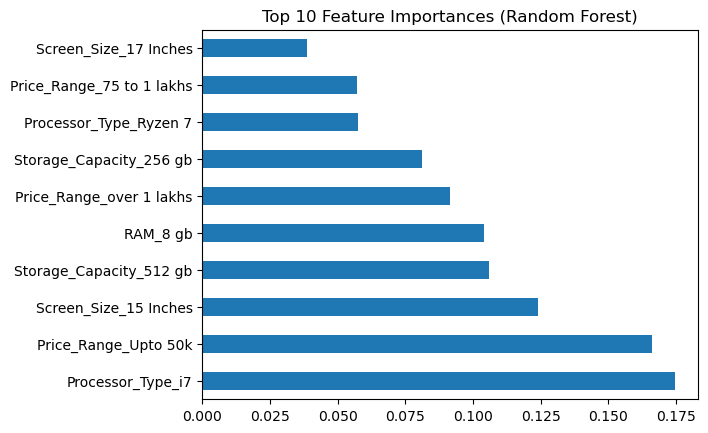

In [58]:
# Visualization
# Plot feature importances for Random Forest
# Ensure the length of feature importances matches the length of feature names
feature_importances = pd.Series(best_rf.feature_importances_, index=encoder.get_feature_names_out()[selector.support_])
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

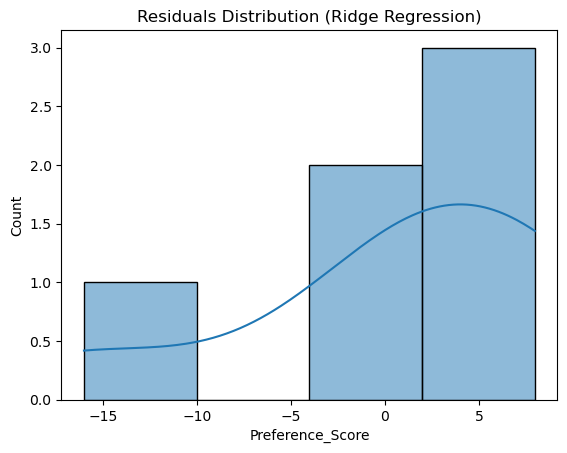

In [54]:
# Plot residuals for Ridge regression
residuals = y_test - y_pred_ridge
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (Ridge Regression)')
plt.show()